This file will cover the entire data pipeline process for acquiring all the data, cleaning, and processing for the sake of this project

# Importing and configurations, also folder setup

In [65]:
!pip install pandas numpy matplotlib seaborn scikit-learn

zsh:1: command not found: pip


In [66]:
import os # Note: for working with folders / paths
from datetime import datetime

import pandas as pd
import yfinance as yf             # Note: To download stock/market data
from fredapi import Fred          # Note: To download macroeconomic data from FRED
from pytrends.request import TrendReq  # Note: To pull Google Trends sentiment data
import duckdb                     # Note: This one for now is unsure-ish, can be used for storing/querying data with SQL

# Note: This is the BASE_DIR = the folder where this notebook is running
BASE_DIR = os.getcwd()

# # Note: This will be the main data directory:
DATA_DIR = os.path.join(BASE_DIR, "data")

# Note: Subfolders for different stages of the pipeline:
RAW_DIR = os.path.join(DATA_DIR, "raw")
CLEANED_DIR = os.path.join(DATA_DIR, "cleaned")
MERGED_DIR = os.path.join(DATA_DIR, "merged")

# Note: Now also creating more specific subfolders for raw data, each housing different stuff:
# Note: data/raw/prices/     -> raw price data (S&P 500, VIX, etc.)
# Note: data/raw/macro/      -> raw macro data (CPI, unemployment, etc.)
# Note: data/raw/sentiment/  -> raw sentiment data (Google Trends, etc.)
RAW_PRICES_DIR = os.path.join(RAW_DIR, "prices")
RAW_MACRO_DIR = os.path.join(RAW_DIR, "macro")
RAW_SENTIMENT_DIR = os.path.join(RAW_DIR, "sentiment")

# Note: Same structure for cleaned data:
# Note: data/cleaned/prices/
# Note: data/cleaned/macro/
# Note: data/cleaned/sentiment/
CLEAN_PRICES_DIR = os.path.join(CLEANED_DIR, "prices")
CLEAN_MACRO_DIR = os.path.join(CLEANED_DIR, "macro")
CLEAN_SENTIMENT_DIR = os.path.join(CLEANED_DIR, "sentiment")

# Note: We want historical data starting from 1980, so setting that as a golbal variable
START_DATE = "1980-01-01"

# Note: Today's date (so we always pull up-to-date data)
TODAY = datetime.today().strftime("%Y-%m-%d")

# Note: These will be the financial tickers (for yfinance)
# Note: ^GSPC = S&P 500 index; ^VIX  = Volatility Index
TICKERS = {
    "sp500": "^GSPC",
    "vix": "^VIX",
}

# Note: Next we have the FRED macroeconomic series IDs
# Note: These IDs come from the FRED website
FRED_SERIES = {
    "cpi": "CPIAUCSL",           # Note: Consumer Price Index
    "unemployment": "UNRATE",    # Note: Unemployment rate
    "fed_funds_rate": "FEDFUNDS",
    "m2_money_stock": "M2SL",
}

# Note: Finally the Google Trends sentiment settings
# Note: These are some of the keywords we care about for sentiment around crashes/recessions.
# TRENDS_KEYWORDS = [
#     # "recession",
#     # "stock market crash",
#     # "bear market",
#     # "financial crisis",
#     # "economic crisis",
#     # "market crash",
#     # "economic collapse",
#     # "market panic",
#     # "market volatility",
#     # "stock crash",
#     # "credit crunch",
#     # "bank run",
#     # "bank collapse",
#     # "investor panic",
#     # "yield curve inversion", 
#     # "inflation crisis",
#     # "stagflation",
#     # "should I sell my stocks",
#     # "why is the stock market dropping",
#     # "market uncertainty",
#     # "fed meeting",
#     # "inflation report",
#     # "jobs report"
# ]
# Note: Google Trends only goes back to 2004, so our sentiment data starts then.
# TRENDS_START_DATE = "2004-01-01"

# Note: Let's print it so we can make sure most of this configuration and folder setup worked
print("Base directory:", BASE_DIR)
print("Data directory:", DATA_DIR)
print("Raw data folder:", RAW_DIR)
print("Cleaned data folder:", CLEANED_DIR)
print("Merged data folder:", MERGED_DIR)


ModuleNotFoundError: No module named 'yfinance'

# Acquire price data (S&P 500 + VIX) by downloading all of it

In [ ]:
# Note: This is where we will download the actual price data using yfinance, this includes the S&P 500 (^GSPC) and the VIX index (^VIX)
# Note: We'll pull all data from our START_DATE (1980) up through TODAY
# Note: The print statements below are practices we are adopting so as to make sure at each step we understand what is causing an error if something happens for debugging

def download_prices(name, ticker, start=START_DATE, end=TODAY):
    # Note: This function downloads price data for a given ticker.
    # Note: 'name' is just our friendly label like "sp500".
    # Note: 'ticker' is the actual Yahoo Finance symbol like "^GSPC".

    print(f"[prices] Downloading {name} ({ticker}) from {start} to {end} ...")

    # Note: yf.download() pulls OHLCV data (Open, High, Low, Close, Volume)
    df = yf.download(ticker, start=start, end=end)

    # Note: If somehow yfinance returns nothing, we don't want the code to break.
    if df.empty:
        print(f"[prices] WARNING: no data returned for {ticker}")
        return None
    
    # Note: So first gotta convert all column names into plain strings because one of the column names in yfinance seem to not be str but a tuple
    df.columns = df.columns.map(str)

    # Note: Moving the index into a normal 'date' column and cleaning column names a bit.
    df = df.reset_index()
    df.columns = [c.lower().replace(" ", "_") for c in df.columns]

    return df


def save_prices(df, name):
    # Note: This function simply saves the dataframe to the correct folder.
    # Note: If df is None or empty, then there's nothing to save.

    if df is None or df.empty:
        print(f"[prices] Nothing to save for {name}")
        return

    # Note: Construct the path like: data/raw/prices/sp500_prices_raw.csv
    out_path = os.path.join(RAW_PRICES_DIR, f"{name}_prices_raw.csv")

    # Note: Saving all of the data
    df.to_csv(out_path, index=False)

    print(f"[prices] Saved {name} data to {out_path} (rows: {len(df)})")


# Note: Now we loop through all tickers we defined earlier (S&P 500 + VIX)
# Note: For each ticker, we download it and then save it.
for name, ticker in TICKERS.items():
    df = download_prices(name, ticker)
    save_prices(df, name)


# Get the macro data from FRED

In [ ]:
# Note: For loading the .env variables like API keys
from dotenv import load_dotenv
load_dotenv()

# Note: Already went to the FRED website and got an API key, which is in the .env (so git won't track it), so will use that for this step
# Note: Now we move on to downloading macroeconomic data from FRED
# Note: This will give us things like CPI, unemployment, Fed funds rate, and M2 money stock

# Note: Just pulling that API key from the .env
FRED_API_KEY = os.getenv("FRED_API_KEY")



# Note: Now we will create the FRED client using the key
fred = None
try:
    fred = Fred(api_key=FRED_API_KEY)
    print("Successfully connected to FRED")
except Exception as e:
    print("Error connecting to FRED:", e)
    fred = None


def download_fred_series(series_id, start=START_DATE, end=TODAY):
    # Note: This function downloads ONE macro time series from FRED, example series_id values would be like "CPIAUCSL", "UNRATE", etc

    # Note: This print is to make sure the client was created properly, to make sure if problems happen we can find out where what went wrong
    if fred is None:
        print(f"FRED client is not initialized.")
        return None

    print(f"[macro] Downloading FRED series {series_id} from {start} to {end} ...")

    try:
        series = fred.get_series(series_id, observation_start=start, observation_end=end)
    except Exception as e:
        print(f"Error downloading series {series_id}:", e)
        return None

    if series is None or series.empty:
        print(f"Data was not returned for series {series_id}")
        return None

    # Note: Turning the series into a DataFrame with columns: date, value
    df = series.to_frame(name="value")
    df.index.name = "date"
    df = df.reset_index()

    return df


def save_macro(df, name):
    # Note: This function saves the macro DataFrame into data/raw/macro/
    if df is None or df.empty:
        print(f"Nothing to save for {name}")
        return

    out_path = os.path.join(RAW_MACRO_DIR, f"{name}_fred_raw.csv")
    df.to_csv(out_path, index=False)
    print(f"Saved {name} data to {out_path} (rows: {len(df)})")


# Note: Now we loop over all the FRED series we defined earlier in FRED_SERIES
# Note: Keys are our friendly names (cpi, unemployment, etc.), values are the actual FRED IDs
for name, series_id in FRED_SERIES.items():
    df_macro = download_fred_series(series_id)
    save_macro(df_macro, name)


# Google Trends Sentiment Data

In [ ]:
"""

# Note: Now we move on to Google Trends sentiment data using pytrends
# Note: Google Trends only goes back to 2004, which is fine
# Note: We'll pull sentiment for these keywords: ["recession", "stock market crash", "bear market", "financial crisis"]

# Note: Okay so first try got code 429 error, indicating that Google did not allow too many requests in a short span
# Note: Basically what happened was it downloaded for some keywords and did not for some, indicating to many requests too quick basically
# Note: Idea is to retry with a waittime basically
# Note: Here's some notes, seems like it was not related to the time issue, since it still is not working with a workaround for 60s waittime
# Note: Upon further research it seems like this has more to do with automated requests
# Note: New idea is to now try one keyword at a time, with a fresh pytrends session for each call and manually control it

# Note: Initialize the pytrends connection
# Note: Can use any timezon but we'll use US for simplicity
# pytrends = TrendReq(hl='en-US', tz=360)




def download_trends_keyword(keyword, start_date=TRENDS_START_DATE, end_date=TODAY):
    # Note: This function downloads the Google Trends "interest over time" for ONE keyword
    # Note: Google Trends needs the format "YYYY-MM-DD YYYY-MM-DD", all in one string

    print(f"Downloading Google Trends data for '{keyword}'...")

    try:
        # Note: Build the timeframe in the format Google Trends expects
        timeframe = f"{start_date} {end_date}"

        # Note: IMPORTANT CHANGE:
        # Note: Instead of one global pytrends object, we create a fresh TrendReq() per keyword call.
        # Note: This sometimes helps when Google has rate-limited a previous session.
        local_pytrends = TrendReq(hl='en-US', tz=360)

        # Note: pytrends requires that we "build a payload" before fetching data
        local_pytrends.build_payload([keyword], cat=0, timeframe=timeframe, geo='', gprop='')

        # Note: Now we can request the interest-over-time data.
        df = local_pytrends.interest_over_time()

        if df.empty:
            print(f"No data returned for keyword '{keyword}'")
            return None

        # Note: interest_over_time() returns a dataframe with the keyword and an 'isPartial' column
        # Note: We only care about the keyword and the date, so we will clean it up a bit
        df = df.reset_index()

        # Note: Some column names may have spaces or weird formatting, so we can clean that up too
        df.columns = [c.lower().replace(" ", "_") for c in df.columns]

        # Note: Will also drop the 'ispartial' column since we don’t need it
        if "ispartial" in df.columns:
            df = df.drop(columns=["ispartial"])

        # Note: Also rename the keyword column to something predictable
        df = df.rename(columns={keyword.lower().replace(" ", "_"): "value"})

        return df

    except Exception as e:
        print(f"Error downloading keyword '{keyword}':", e)
        return None


def save_trends(df, keyword):
    # Note: This function saves the sentiment dataframe into data/raw/sentiment/
    if df is None or df.empty:
        print(f"[sentiment] Nothing to save for '{keyword}'")
        return

    # Note: Just making sure to format the filename nicely, like: recession_trends_raw.csv
    filename = f"{keyword.lower().replace(' ', '_')}_trends_raw.csv"
    out_path = os.path.join(RAW_SENTIMENT_DIR, filename)

    df.to_csv(out_path, index=False)
    print(f"Saved keyword '{keyword}' to {out_path} (rows: {len(df)})")

# Note: We are NOT looping through all TRENDS_KEYWORDS automatically anymore.
# Note: Instead, we will call download_trends_keyword() and save_trends() manually, one keyword at a time in separate cells.

"""

In [ ]:
"""

# Note: Now going to call it with one keyword at a time to see if that works
# Note: Trying with "recession"

keyword = "inflation"
df_trend = download_trends_keyword(keyword)
save_trends(df_trend, keyword)

# Note: Funnily, tried wustl-encrypted, then my personal hotspot, and it did not but worked on eduroam
# Note: Now this kernel will just go through the trendkeywords from the first kernel and download for each keyword
# import time

# for keyword in TRENDS_KEYWORDS:
#     print(f"Starting download for keyword: '{keyword}'")

#     df_trend = download_trends_keyword(keyword)
#     save_trends(df_trend, keyword)

#     # Note: Making sure to have a quick pause so Google does not stop us again, but this should not be an issue since we are starting a new session each time
#     time.sleep(30)


"""

## Change to the idea

Google Trends is throwing 429 errors, and so for now we will scrap the idea of sentiment analysis, and move on with the rest of the code. We tried multiple devices to see if it was an IP thing, we also tried doing one keyword at a time restarting the kernel, or changing the wifi networks, also kept a timer in between but it seems to not be working. We will work with what we have and research more as we move on with the project to see what we can add on.

# Cleaning the Price Data

In [ ]:
# Note: Now we move on to CLEANING the price data, this includes both the S&P 500 (^GSPC) and the VIX (^VIX).
# Note: The raw CSV files live in data/raw/prices/, and we will output cleaned versions into data/cleaned/prices/
# Note: Cleaning steps will involve parsing the date column properly, lowercasing + underscoring column names, sorting chronologically, forward-filling missing values (common in VIX / holidays)
# Note: And then we can save the clean CSVs

def clean_price_file(raw_path, out_path):
    df = pd.read_csv(raw_path)
    # Note: Next step is to clean the columns, because the yfinance has weird tuple-like column names int he CSV files
    # Note: Will clean the column names by stripping the parentheses, splitting on the commas, taking the first part, and also lowercase and underscoring
    def clean_col_name(c):
        c_str = str(c).strip()
        if c_str.startswith("(") and "," in c_str:
            # Example: "('close',_'^gspc')" -> "close"
            inner = c_str.strip("()")
            parts = inner.split(",")
            base = parts[0].strip().strip("'").strip('"')
            return base.lower().replace(" ", "_")
        else:
            return c_str.lower().replace(" ", "_")

    df.columns = [clean_col_name(c) for c in df.columns]

    # Note: Parse the date column (sometimes named "date")
    if "date" in df.columns:
        df["date"] = pd.to_datetime(df["date"])
    else:
        # Note: If the date is the index instead (chances of which are pretty low), we will take care of that by resetting the index
        df = df.reset_index()
        df["date"] = pd.to_datetime(df["date"])

    # Note: Sort data by date just to be safe
    df = df.sort_values("date").reset_index(drop=True)

    # Note: Forward-fill missing values, this is very normal — holidays, partial trading days, etc.
    numeric_cols = df.select_dtypes(include=["float", "int"]).columns
    df[numeric_cols] = df[numeric_cols].ffill()

    # Note: Save cleaned file
    df.to_csv(out_path, index=False)
    print(f"Saved cleaned file → {out_path} (rows: {len(df)})")


# Note: These are our price files to clean
PRICE_FILES = {
    "sp500": "sp500_prices_raw.csv",
    "vix": "vix_prices_raw.csv"
}

# Note: Loop through each raw file and run the function above to clean it
for name, filename in PRICE_FILES.items():
    raw_path = os.path.join(RAW_PRICES_DIR, filename)
    out_path = os.path.join(CLEAN_PRICES_DIR, f"{name}_prices_clean.csv")

    print(f"\nCleaning price data for: {name}")
    
    if not os.path.exists(raw_path):
        print(f"Raw file does NOT exist → {raw_path}")
        continue

    clean_price_file(raw_path, out_path)


# Cleaning the Macroeconomic data from FRED

In [ ]:
# Note: Now we move on to CLEANING the macroeconomic data we pulled from FRED.
# Note: Raw macro files are in data/raw/macro/, and we will save cleaned versions into data/cleaned/macro/.
# Note: The files (from our earlier download) should be: cpi_fred_raw.csv, unemployment_fred_raw.csv, fed_funds_rate_fred_raw.csv, m2_money_stock_fred_raw.csv
# Note: Cleaning steps will involve: parsing the 'date' column, making sure 'value' is numeric, sorting by date, forward-filling missing macro values (which is very normal for monthly/irregular data)
# Note: And then we can save it as *_fred_clean.csv
# Note: The idea around the forward filling, as we did earlier too is in the case of missing values in a time series, its just to replace the last known valid value, using an inbuilt pandas function

def clean_macro_file(raw_path, out_path):
    df = pd.read_csv(raw_path)

    # Note: Expecting columns: 'date' and 'value', from where we can parse 'date' to datetime
    if "date" in df.columns:
        df["date"] = pd.to_datetime(df["date"])
    else:
        print(f"'date' column not found in {raw_path}.")
        return

    # Note: Ensuring 'value' is numeric; also changing any non-numeric values to NaN
    if "value" in df.columns:
        df["value"] = pd.to_numeric(df["value"], errors="coerce")
    else:
        print(f"'value' column not found in {raw_path}.")
        return

    # Note: Sorting by date
    df = df.sort_values("date").reset_index(drop=True)

    # Note: Forward-filling any missing values (macro series often have gaps or delays)
    df["value"] = df["value"].ffill()

    # Note: Saving the cleaned file
    df.to_csv(out_path, index=False)
    print(f"Saved cleaned file for {out_path} (rows: {len(df)})")


# Note: These will be our macro files to clean
MACRO_FILES = {
    "cpi": "cpi_fred_raw.csv",
    "unemployment": "unemployment_fred_raw.csv",
    "fed_funds_rate": "fed_funds_rate_fred_raw.csv",
    "m2_money_stock": "m2_money_stock_fred_raw.csv",
}

# Note: Loop through each raw macro file and clean it
for name, filename in MACRO_FILES.items():
    raw_path = os.path.join(RAW_MACRO_DIR, filename)
    out_path = os.path.join(CLEAN_MACRO_DIR, f"{name}_fred_clean.csv")

    print(f"\nCleaning macro data for: {name}")

    if not os.path.exists(raw_path):
        print(f"Raw macro file does NOT exist for {raw_path}")
        continue

    clean_macro_file(raw_path, out_path)


# Pulling in Extra FRED Data

After further research, we realized that we could pull more data from the FRED dataset that we could actually use to make our predictor even better, in the following kernel we can see that under EXTRA_FRED_DATA, where we will pull all of those to raw, and then clean them up like we have done for the price and macro and we will then merge everything together, since with Sentiment Analysis out of the picture, this makes more sense to have right now.

In [ ]:
# Note: Okay so now we're adding MORE macro series from FRED to beef up the dataset
# Note: Keeping the same friendly naming convention as before so we can merge later

EXTRA_FRED_DATA = {
    # Note: These will be for Housing / credit
    "home_prices_case_shiller": "CSUSHPINSA",   # Note: Case-Shiller Home Price Index (national, seasonally adjusted)
    "housing_starts": "HOUST",                  # Note: Housing starts
    "building_permits": "PERMIT",               # Note: Building permits (leading housing indicator)
    "mortgage_30y": "MORTGAGE30US",             # Note: 30-year fixed mortgage rate

    # Note: These are for Rates / yield curve / inflation expectations
    "t10y": "DGS10",                            # Note: 10-year Treasury yield
    "t2y": "DGS2",                              # Note: 2-year Treasury yield
    "t3m": "DGS3MO",                            # Note: 3-month Treasury yield
    "real_10y": "DFII10",                       # Note: 10-year TIPS (real yield)
    "breakeven_10y": "T10YIE",                  # Note: 10-year breakeven inflation (expected inflation)

    # Note: These are for Inflation breadth
    "cpi_core": "CPILFESL",                     # Note: Core CPI (ex-food/energy)
    "pce_headline": "PCEPI",                    # Note: Headline PCE
    "pce_core": "PCEPILFE",                     # Note: Core PCE

    # Note: These are for Labor high-frequency
    "initial_claims": "ICSA",                   # Note: Weekly initial jobless claims
    "continuing_claims": "CCSA",                # Note: Continuing claims

    # Note: These are for Sentiment / leading indicators
    "umich_sentiment": "UMCSENT",               # Note: University of Michigan Consumer Sentiment
    "leading_index": "USSLIND",                 # Note: Conference Board Leading Index (US)

    # Note: These are for Financial stress / credit
    "stl_fsi": "STLFSI2",                       # Note: St. Louis Financial Stress Index
    "high_yield_spread": "BAMLH0A0HYM2",        # Note: High-yield corporate spread

    # Note: These are for Activity / PMI / utilization
    "ism_manufacturing_pmi": "NAPM",            # Note: ISM Manufacturing PMI
    "capacity_utilization": "TCU",              # Note: Capacity utilization
    "industrial_production": "INDPRO",          # Note: Industrial production index

    # Note: These are for Commodities / liquidity proxies
    "wti_oil": "DCOILWTICO",                    # Note: WTI crude oil price
    "gold_fix": "GOLDAMGBD228NLBM",             # Note: Gold (London fix)
}

# Note: Now we will loop through each new series, download via the same helper, and save to data/raw/macro/
for name, series_id in EXTRA_FRED_DATA.items():
    print(f"\n[macro-extra] Downloading {name} ({series_id}) ...")
    df_macro = download_fred_series(series_id)
    save_macro(df_macro, name)

Two things did not download, the ism_manufacturing_pmi and the other one is the gold_fix for, but since we have a lot of other data we are ready to move onto the next step.

# Cleaning up all the new Extra Data

In [ ]:
# Note: Now we will clean all the extra macro series we just downloaded.
# Note: Will follow the same pattern: parse date, coerce numeric, sort, forward-fill, then save to data/cleaned/macro/

def clean_extra_macro_file(raw_path, out_path):
    # Note: Read the raw CSV we saved earlier
    df = pd.read_csv(raw_path)

    # Note: Checking for the required columns
    if "date" not in df.columns or "value" not in df.columns:
        print(f"[macro-extra] Missing 'date' or 'value' in {raw_path}")
        return

    # Note: Here we parse the dates and coerce values to numeric (turn bad strings into NaN)
    df["date"] = pd.to_datetime(df["date"])
    df["value"] = pd.to_numeric(df["value"], errors="coerce")

    # Note: Sorting by date so forward-fill behaves as expected
    df = df.sort_values("date").reset_index(drop=True)

    # Note: Forward-filling to cover gaps (common for monthly/weekly series)
    df["value"] = df["value"].ffill()

    # Note: Saving the cleaned file to the cleaned/macro folder
    df.to_csv(out_path, index=False)
    print(f"[macro-extra] Saved cleaned file → {out_path} (rows: {len(df)})")

# Note: Mapping of the names to their raw filenames (same as the download step) from earlier
FILES_FOR_EXTRA_MACRO_DATA = {
    "home_prices_case_shiller": "home_prices_case_shiller_fred_raw.csv",
    "housing_starts": "housing_starts_fred_raw.csv",
    "building_permits": "building_permits_fred_raw.csv",
    "mortgage_30y": "mortgage_30y_fred_raw.csv",
    "t10y": "t10y_fred_raw.csv",
    "t2y": "t2y_fred_raw.csv",
    "t3m": "t3m_fred_raw.csv",
    "real_10y": "real_10y_fred_raw.csv",
    "breakeven_10y": "breakeven_10y_fred_raw.csv",
    "cpi_core": "cpi_core_fred_raw.csv",
    "pce_headline": "pce_headline_fred_raw.csv",
    "pce_core": "pce_core_fred_raw.csv",
    "initial_claims": "initial_claims_fred_raw.csv",
    "continuing_claims": "continuing_claims_fred_raw.csv",
    "umich_sentiment": "umich_sentiment_fred_raw.csv",
    "leading_index": "leading_index_fred_raw.csv",
    "stl_fsi": "stl_fsi_fred_raw.csv",
    "high_yield_spread": "high_yield_spread_fred_raw.csv",
    "capacity_utilization": "capacity_utilization_fred_raw.csv",
    "industrial_production": "industrial_production_fred_raw.csv",
    "wti_oil": "wti_oil_fred_raw.csv",
}

# Note: Finally, we will loop through each raw file, clean it, and save the *_fred_clean.csv for that one tot he clean like we did w earlier
for name, filename in FILES_FOR_EXTRA_MACRO_DATA.items():
    raw_path = os.path.join(RAW_MACRO_DIR, filename)
    out_path = os.path.join(CLEAN_MACRO_DIR, f"{name}_fred_clean.csv")

    print(f"\n[macro-extra] Cleaning extra macro data for: {name}")

    if not os.path.exists(raw_path):
        print(f"[macro-extra] Raw macro file does NOT exist → {raw_path}")
        continue

    clean_extra_macro_file(raw_path, out_path)

# Merging everything into one, clean up columns too

In [ ]:
# Note: This is the cell for cleaning up the column names and stuff from yfinance (tuple names) and outputs a perfectly structured dataset for analysis and also merging everything

def load_clean_price(name):
    # Note: Loading each cleaned price file by name (sp500 or vix)
    path = os.path.join(CLEAN_PRICES_DIR, f"{name}_prices_clean.csv")
    df = pd.read_csv(path)
    df["date"] = pd.to_datetime(df["date"])
    return df


def load_clean_macro(name):
    # Note: Loading each cleaned macro file by name
    path = os.path.join(CLEAN_MACRO_DIR, f"{name}_fred_clean.csv")
    df = pd.read_csv(path)
    df["date"] = pd.to_datetime(df["date"])
    return df


# Note: Loading price data ---
df_sp500 = load_clean_price("sp500")
df_vix = load_clean_price("vix")

# Note: Renaming columns so they are clean and readable
df_sp500 = df_sp500.rename(columns={
    "open": "open_sp500",
    "high": "high_sp500",
    "low": "low_sp500",
    "close": "close_sp500",
    "volume": "volume_sp500",
})

df_vix = df_vix.rename(columns={
    "open": "open_vix",
    "high": "high_vix",
    "low": "low_vix",
    "close": "close_vix",
    "volume": "volume_vix",
})


# Note: Merging the price data
merged = pd.merge(df_sp500, df_vix, on="date", how="inner")
print("After merging prices:", merged.shape)

# Note: This is where we add the new addition, the extra macro data, first thing we will do is we will add all the new stuff to the 
# macro_series list and then we will loop through each one and load it, rename it to the name of the macro series, and then merge it


# Note: Loading and merging the macro series data
macro_series = ["cpi", "unemployment", "fed_funds_rate", "m2_money_stock", "home_prices_case_shiller", "housing_starts", "building_permits", "mortgage_30y",
    "t10y", "t2y", "t3m", "real_10y", "breakeven_10y", "cpi_core", "pce_headline", "pce_core", "initial_claims", "continuing_claims",
    "umich_sentiment", "leading_index", "stl_fsi", "high_yield_spread", "capacity_utilization", "industrial_production", "wti_oil"]

# Note: Now gonna loop through each one and load it and rename the value to the name of the macro and merge everything together
for macro in macro_series:
    df_macro = load_clean_macro(macro)
    print(f"Merging macro variable: {macro}")

    # Note: Renaming "value" to macro series name
    df_macro = df_macro.rename(columns={"value": macro})

    merged = pd.merge(
        merged,
        df_macro,
        on="date",
        how="left"     # Note: Making sure all daily dates are kept
    )


# Note: Sorting + forward-filling macro values
merged = merged.sort_values("date").reset_index(drop=True)
merged[macro_series] = merged[macro_series].ffill()


# Note: Saving final merged dataset
output_path = os.path.join(MERGED_DIR, "merged_dataset_cleaned.csv")
merged.to_csv(output_path, index=False)

print(f"Final merged dataset saved to {output_path}")
print(f"Final shape: {merged.shape}")
print(merged.head())



***One final note, for the macro dataset, interestingly that starts on February 1, instead of January 1, which is why it shows up as having no value for the first month of 1990, where as the prices start 1990 January 1.***

# Data visualizations

This section produces quick exploratory plots for the merged dataset: time series, correlation heatmap, pairwise plots, and rolling correlations. Plots are saved to `output/plots/`.

In [ ]:
# Visualization imports and setup
# This cell defensively ensures plotting packages are available in the running kernel,
# defines path variables if missing, and prepares the plots folder.
import os, sys, subprocess, importlib
# Try to enable inline plotting when running inside IPython/Jupyter
try:
    get_ipython().run_line_magic('matplotlib', 'inline')
except Exception:
    pass

# Defensive path defaults in case earlier config cell was not executed
BASE_DIR = globals().get('BASE_DIR', os.getcwd())
DATA_DIR = globals().get('DATA_DIR', os.path.join(BASE_DIR, 'data'))
RAW_DIR = globals().get('RAW_DIR', os.path.join(DATA_DIR, 'raw'))
CLEANED_DIR = globals().get('CLEANED_DIR', os.path.join(DATA_DIR, 'cleaned'))
MERGED_DIR = globals().get('MERGED_DIR', os.path.join(DATA_DIR, 'merged'))

def ensure_installed(packages):
    """Install packages into the current Python executable if missing."""
    for pkg in packages:
        try:
            importlib.import_module(pkg)
        except Exception:
            print(f'Installing {pkg} into {sys.executable} ...')
            subprocess.check_call([sys.executable, '-m', 'pip', 'install', '--upgrade', pkg])
            importlib.invalidate_caches()

# Ensure matplotlib and seaborn are available (no-op if already installed)
ensure_installed(['matplotlib', 'seaborn'])

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

print('Python:', sys.executable)
print('matplotlib:', matplotlib.__version__)
print('seaborn:', sns.__version__)

# Make sure output directory exists
PLOTS_DIR = os.path.join(BASE_DIR, 'output', 'plots')
os.makedirs(PLOTS_DIR, exist_ok=True)

# Load merged dataset (if present). We don't raise here to keep the notebook interactive.
merged_path = os.path.join(MERGED_DIR, 'merged_dataset_cleaned.csv')
if not os.path.exists(merged_path):
    print(f'Warning: Merged dataset not found: {merged_path} -- plotting cells will skip if run')
    df = None
else:
    df = pd.read_csv(merged_path, parse_dates=['date'])
    df = df.sort_values('date').reset_index(drop=True)
    df = df.set_index('date')
    print('Loaded merged dataset:', df.shape)
    print('Columns (sample):', list(df.columns)[:20])

Python: /Library/Developer/CommandLineTools/usr/bin/python3
matplotlib: 3.9.4
seaborn: 0.13.2


NameError: name 'BASE_DIR' is not defined

In [ ]:
# Diagnostic cell: environment, pip, and import attempts
import sys, os, importlib
print('sys.executable ->', sys.executable)
print('Python version ->', sys.version)

# Show pip location/version
try:
    import shutil
    pip_path = shutil.which('pip')
    print('pip executable ->', pip_path)
except Exception as e:
    print('pip location check failed:', e)

# Try importing matplotlib/seaborn and if missing, install via %pip (safe for kernels)
try:
    import matplotlib, seaborn
    print('matplotlib', matplotlib.__version__, 'seaborn', seaborn.__version__)
except Exception as e:
    print('Import failed:', e)
    print('Attempting to install matplotlib and seaborn into the running kernel using %pip...')
    try:
        get_ipython().run_line_magic('pip', 'install --upgrade matplotlib seaborn')
    except Exception as e2:
        print('`%pip install` failed:', e2)

    # Invalidate caches and retry import
    importlib.invalidate_caches()
    try:
        import matplotlib, seaborn
        print('After install: matplotlib', matplotlib.__version__, 'seaborn', seaborn.__version__)
    except Exception as e3:
        print('Still failing to import after install attempt:', e3)
        # Print some helpful diagnostics
        try:
            import subprocess
            print('pip --version output:')
            subprocess.call([sys.executable, '-m', 'pip', '--version'])
        except Exception as e4:
            print('Could not run pip --version:', e4)
        print('If installation fails here, consider:\n - Running this notebook with a kernel that matches the Python you installed packages into\n - Running `python -m pip install --user matplotlib seaborn` in a terminal using the `sys.executable` printed above\n - Creating and selecting a virtualenv/conda env for the notebook')

sys.executable -> /Library/Developer/CommandLineTools/usr/bin/python3
Python version -> 3.9.6 (default, Nov 11 2024, 03:15:38) 
[Clang 16.0.0 (clang-1600.0.26.6)]
pip executable -> None
matplotlib 3.9.4 seaborn 0.13.2


Saved time series plot to /Users/stsloaner/Documents/GitHub/Stock-Market-Crash-Predictor/output/plots/time_series_sp500_vix.png


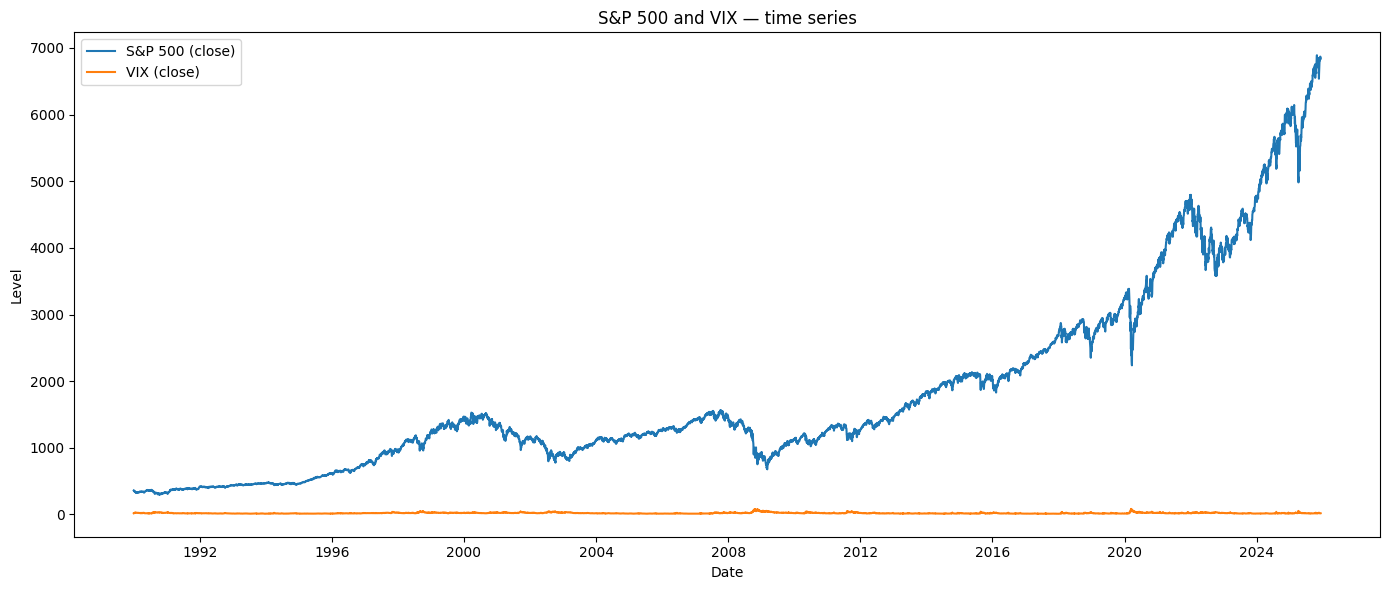

Saved scatter plot to /Users/stsloaner/Documents/GitHub/Stock-Market-Crash-Predictor/output/plots/scatter_return_vs_vix.png


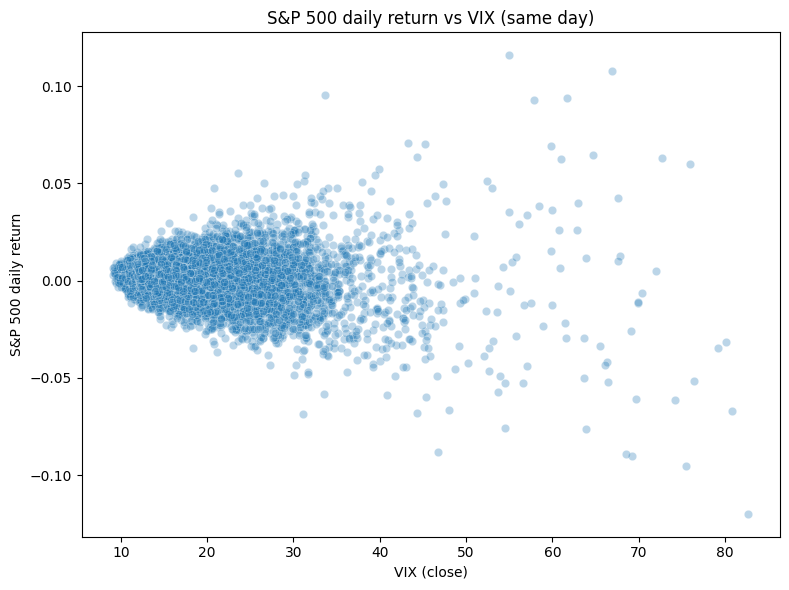

In [67]:
# Basic time-series plots: S&P 500 close and VIX close (if present)
# Defensive imports: import locally in case the setup cell wasn't executed
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Ensure paths exist and load dataframe if not already loaded
base_dir_for_plots = globals().get('BASE_DIR', os.getcwd())
default_plots = os.path.join(base_dir_for_plots, 'output', 'plots')
PLOTS_DIR = globals().get('PLOTS_DIR', default_plots)
os.makedirs(PLOTS_DIR, exist_ok=True)
if 'df' not in globals() or globals().get('df') is None:
    merged_path = os.path.join(globals().get('MERGED_DIR', os.path.join(globals().get('DATA_DIR', os.path.join(globals().get('BASE_DIR', os.getcwd()), 'data')), 'merged')), 'merged_dataset_cleaned.csv')
    if os.path.exists(merged_path):
        df = pd.read_csv(merged_path, parse_dates=['date'])
        df = df.sort_values('date').reset_index(drop=True)
        df = df.set_index('date')
    else:
        print(f'No merged dataset found at {merged_path}. Skipping time-series plots.')
        df = None

if df is None:
    pass
else:
    plt.figure(figsize=(14,6))
    if 'close_sp500' in df.columns:
        sns.lineplot(x=df.index, y=df['close_sp500'], label='S&P 500 (close)')
    if 'close_vix' in df.columns:
        sns.lineplot(x=df.index, y=df['close_vix'], label='VIX (close)')
    plt.title('S&P 500 and VIX — time series')
    plt.xlabel('Date')
    plt.ylabel('Level')
    plt.legend()
    ts_path = os.path.join(PLOTS_DIR, 'time_series_sp500_vix.png')
    plt.tight_layout()
    plt.savefig(ts_path, dpi=150)
    print('Saved time series plot to', ts_path)
    plt.show()

    # Calculate daily returns for S&P 500 if available
    if 'close_sp500' in df.columns:
        df['sp500_return'] = df['close_sp500'].pct_change()

    # Scatter: daily return vs VIX level (same day)
    if 'sp500_return' in df.columns and 'close_vix' in df.columns:
        plt.figure(figsize=(8,6))
        sns.scatterplot(x=df['close_vix'], y=df['sp500_return'], alpha=0.3)
        plt.title('S&P 500 daily return vs VIX (same day)')
        plt.xlabel('VIX (close)')
        plt.ylabel('S&P 500 daily return')
        scatter_path = os.path.join(PLOTS_DIR, 'scatter_return_vs_vix.png')
        plt.tight_layout()
        plt.savefig(scatter_path, dpi=150)
        print('Saved scatter plot to', scatter_path)
        plt.show()

Saved heatmap to /Users/stsloaner/Documents/GitHub/Stock-Market-Crash-Predictor/output/plots/correlation_heatmap.png


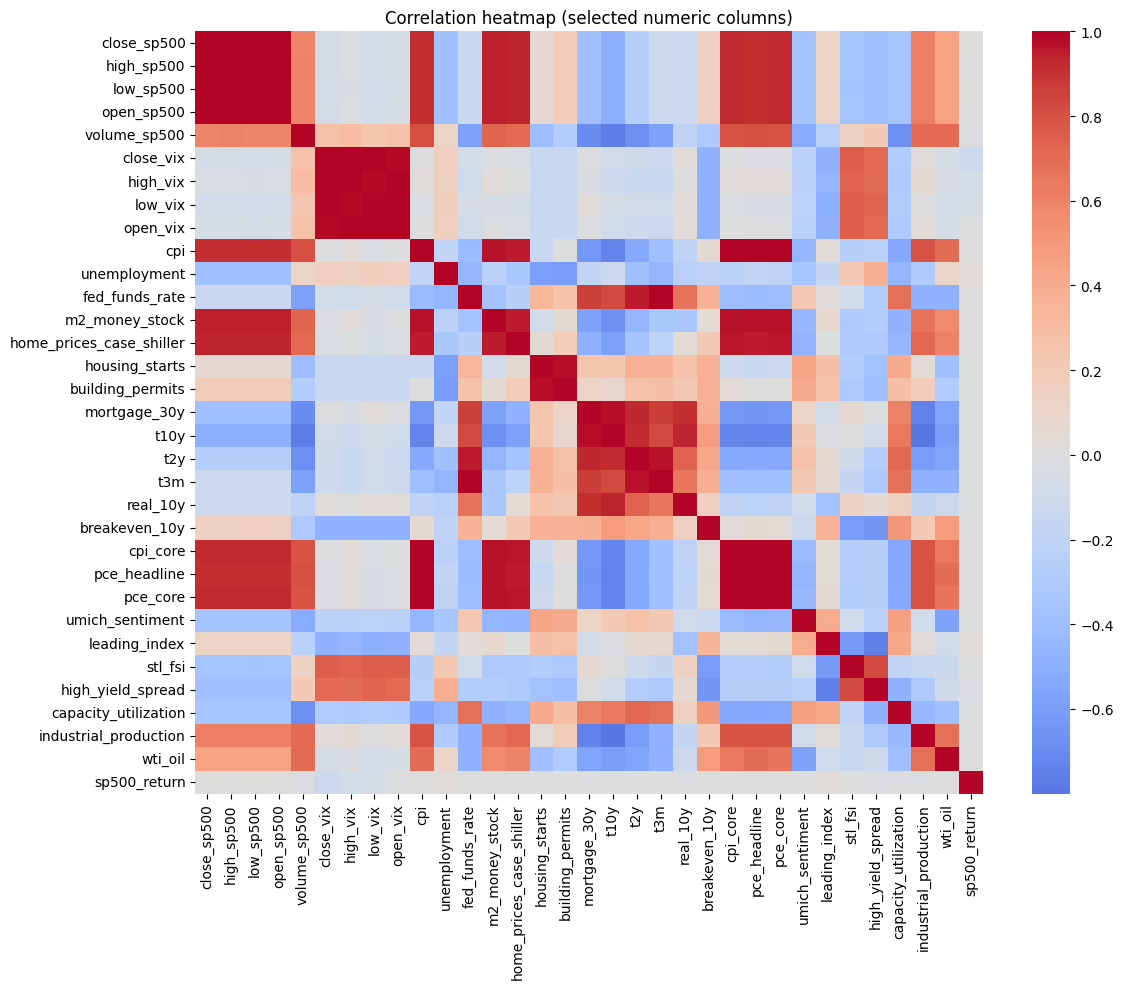

Saved pairplot to /Users/stsloaner/Documents/GitHub/Stock-Market-Crash-Predictor/output/plots/pairplot_sample.png


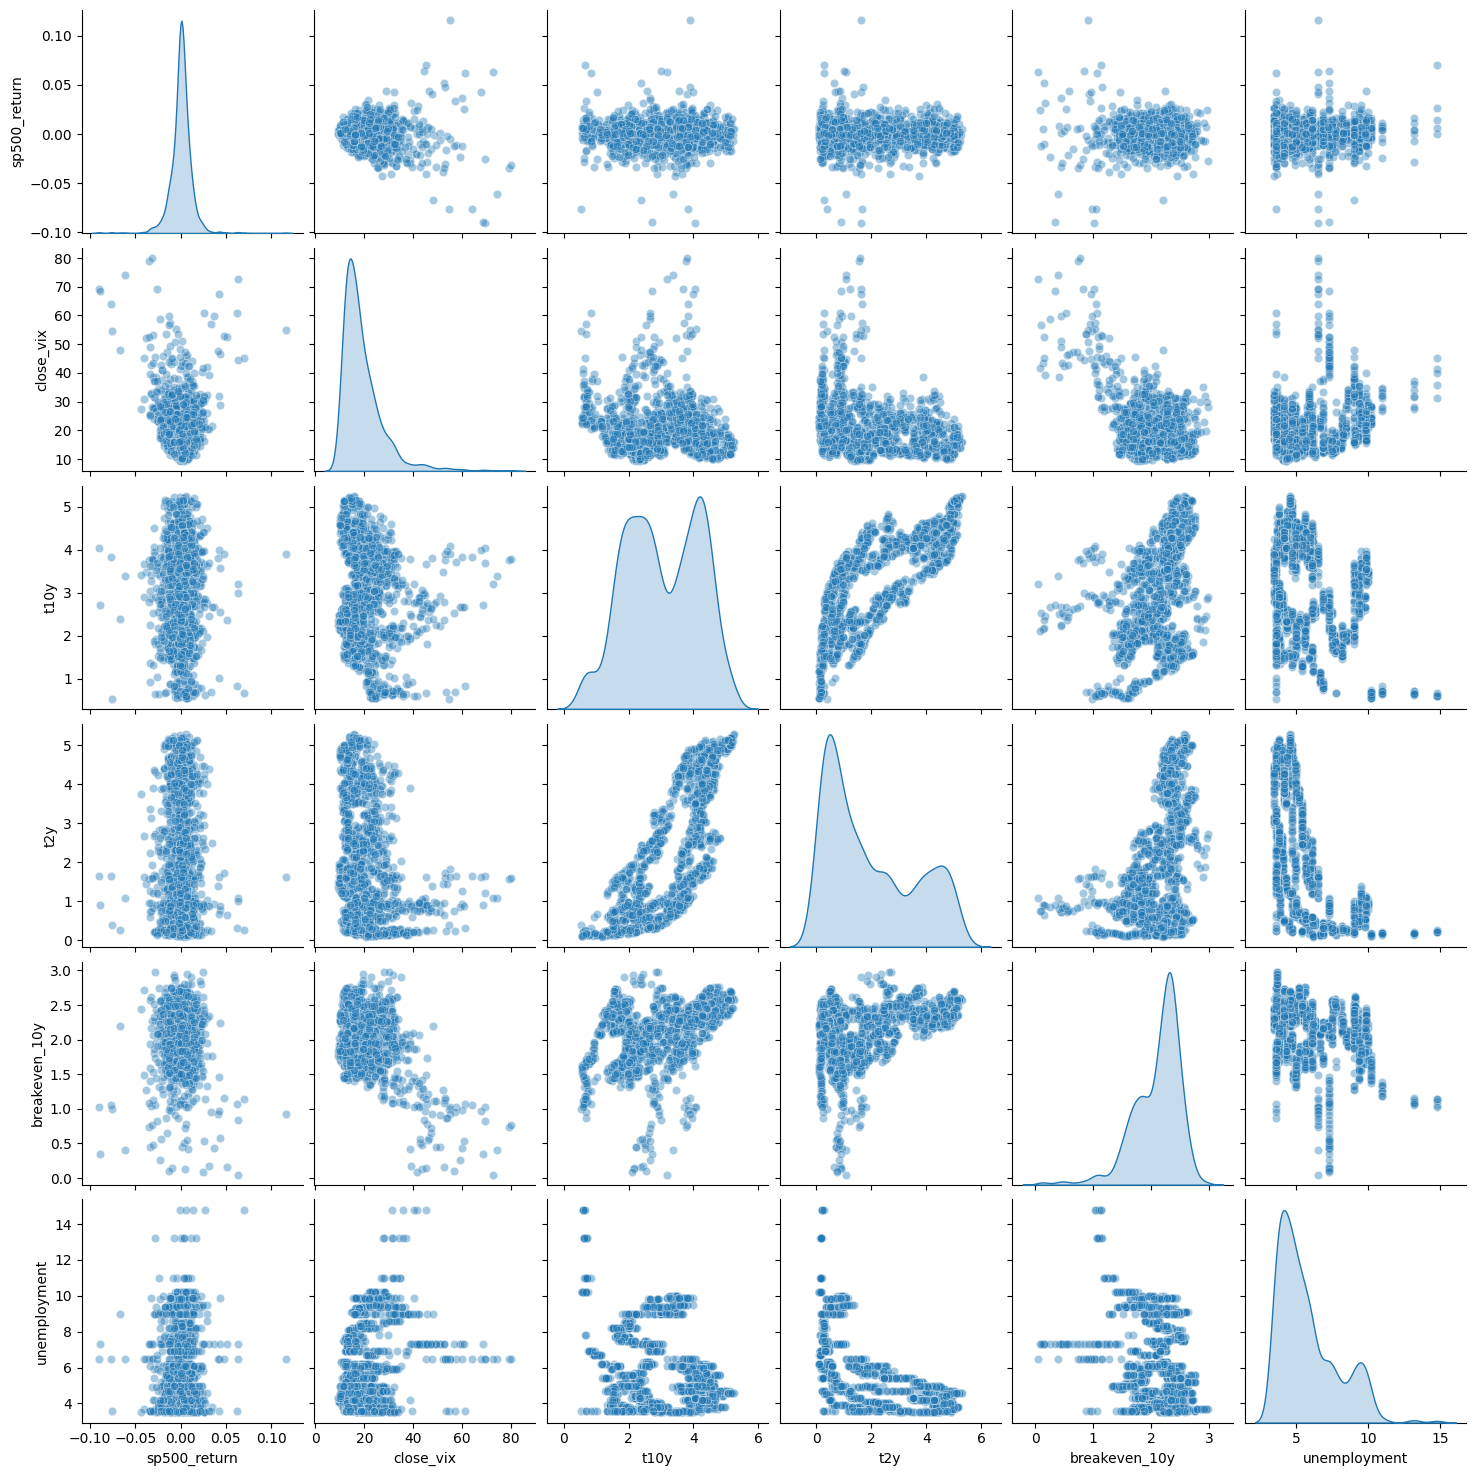

Saved rolling-corr plot to /Users/stsloaner/Documents/GitHub/Stock-Market-Crash-Predictor/output/plots/rolling_corr_return_vix.png


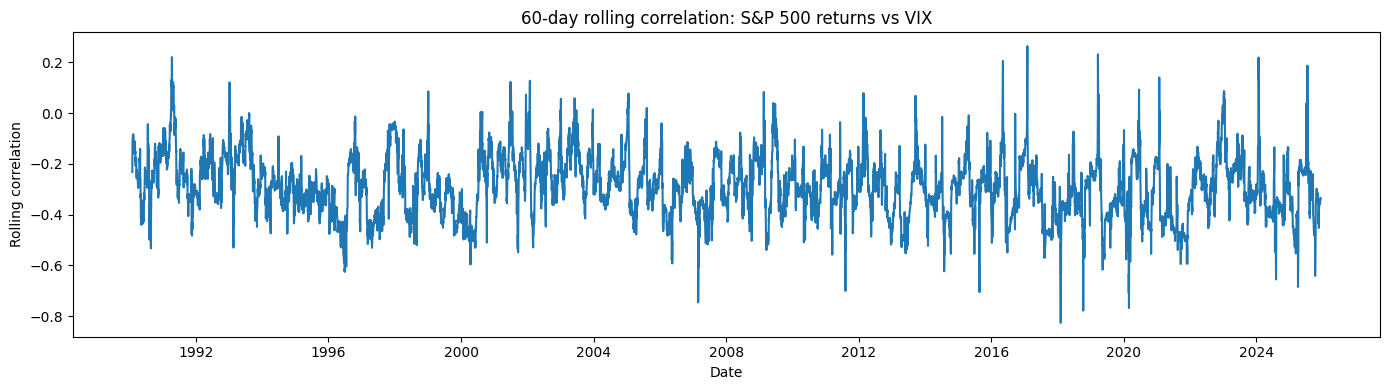

In [68]:
# Correlation heatmap for numeric columns (subset if very wide)
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Ensure plots directory and data are present
base_dir_for_plots = globals().get('BASE_DIR', os.getcwd())
default_plots = os.path.join(base_dir_for_plots, 'output', 'plots')
PLOTS_DIR = globals().get('PLOTS_DIR', default_plots)
os.makedirs(PLOTS_DIR, exist_ok=True)
if 'df' not in globals() or globals().get('df') is None:
    merged_path = os.path.join(globals().get('MERGED_DIR', os.path.join(globals().get('DATA_DIR', os.path.join(globals().get('BASE_DIR', os.getcwd()), 'data')), 'merged')), 'merged_dataset_cleaned.csv')
    if os.path.exists(merged_path):
        df = pd.read_csv(merged_path, parse_dates=['date'])
        df = df.sort_values('date').reset_index(drop=True)
        df = df.set_index('date')
    else:
        print(f'No merged dataset found at {merged_path}. Skipping correlation/pairplot/rolling-corr cells.')
        df = None

if df is None:
    pass
else:
    numeric = df.select_dtypes(include=['number']).copy()
    # Drop columns with too many NaNs or constant values
    numeric = numeric.loc[:, numeric.isna().mean() < 0.5]
    numeric = numeric.loc[:, numeric.apply(lambda x: x.nunique() > 1)]
    if numeric.shape[1] == 0 or numeric.shape[0] == 0:
        print('No numeric columns available for correlation heatmap. Skipping.')
    else:
        cols_for_corr = list(numeric.columns)[:40]  # limit size for readability
        corr = numeric[cols_for_corr].corr()
        plt.figure(figsize=(12,10))
        sns.heatmap(corr, cmap='coolwarm', center=0, annot=False, fmt='.2f')
        plt.title('Correlation heatmap (selected numeric columns)')
        heat_path = os.path.join(PLOTS_DIR, 'correlation_heatmap.png')
        plt.tight_layout()
        plt.savefig(heat_path, dpi=150)
        print('Saved heatmap to', heat_path)
        plt.show()

    # Pairplot for a small set of macro variables + returns (samples to speed up)
    pair_cols_candidates = ['sp500_return', 'close_vix', 't10y', 't2y', 'breakeven_10y', 'unemployment']
    pair_cols = [c for c in pair_cols_candidates if c in df.columns]
    if len(pair_cols) >= 2:
        non_null = df[pair_cols].dropna()
        if non_null.shape[0] == 0:
            print('No complete rows for pairplot. Skipping pairplot.')
        else:
            sample_df = non_null.sample(n=min(2000, len(non_null)), random_state=0)
            try:
                sns.pairplot(sample_df, plot_kws={'alpha':0.4}, diag_kind='kde')
                pair_path = os.path.join(PLOTS_DIR, 'pairplot_sample.png')
                plt.savefig(pair_path, dpi=150)
                print('Saved pairplot to', pair_path)
                plt.show()
            except Exception as e:
                print('Pairplot failed (likely heavy); error:', e)

    # Rolling correlation between S&P returns and VIX (60-day)
    if 'sp500_return' in df.columns and 'close_vix' in df.columns:
        # drop NaNs in the two series to compute rolling correlation cleanly
        tmp = df[['sp500_return', 'close_vix']].dropna()
        if tmp.shape[0] < 20:
            print('Not enough data for rolling correlation (need at least 20 non-null rows). Skipping.')
        else:
            roll = tmp['sp500_return'].rolling(window=60, min_periods=20).corr(tmp['close_vix'])
            plt.figure(figsize=(14,4))
            sns.lineplot(x=roll.index, y=roll.values)
            plt.title('60-day rolling correlation: S&P 500 returns vs VIX')
            plt.xlabel('Date')
            plt.ylabel('Rolling correlation')
            roll_path = os.path.join(PLOTS_DIR, 'rolling_corr_return_vix.png')
            plt.tight_layout()
            plt.savefig(roll_path, dpi=150)
            print('Saved rolling-corr plot to', roll_path)
            plt.show()